# 2c_results_comparison

This notebook compares Task 2 results across the group.

- **2a:** sign detection + sign-type classification
- **2b:** attribute classification

It works by parsing four JSON files, each one containing a summary of results achieved by both models of a particular member.

> Note: To run the notebook, dataset paths needs to be changed since the repo structure had to be modified to align with submission requirements.

In [3]:
# --- Imports ---
from pathlib import Path
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [4]:
# --- Paths ---
# Assumes this notebook sits next to the Result Evals/ folder.
ROOT = Path('.').resolve()
RESULTS = ROOT / 'Result Evals'

# Update this if your repo uses a different location.
print('ROOT   :', ROOT)
print('RESULTS:', RESULTS)
assert RESULTS.exists(), f"Expected Result Evals/ next to notebook. Not found: {RESULTS}"


ROOT   : C:\Users\matth\OneDrive\Documents\UM\Advanced Computer Vision for AI\Group Project
RESULTS: C:\Users\matth\OneDrive\Documents\UM\Advanced Computer Vision for AI\Group Project\Result Evals


## 1) Register group members and where their results are

In [ ]:
# Group configuration (ONE JSON per member)
# Each member should export a single combined evaluation JSON (detector + attribute classifier).
# These are stored in: Result Evals/eval_<name>.json

# Option A (recommended): leave MEMBERS empty and the JSON files will be automatically discovered if placed in the expected directory
# Option B: explicitly list members + the path to their JSON file

MEMBERS = [
    # Example:
    # { 'name': 'Matthias', 'eval_json': 'Result Evals/eval_matthias.json' },
]

AUTO_DISCOVER = True  # set False if you want to rely only on members explicitly listed above


In [6]:
def safe_path(p: str | None) -> Path | None:
    if not p:
        return None
    pp = Path(p)
    if not pp.is_absolute():
        pp = (ROOT / p).resolve()
    return pp

# Quick validation
for m in MEMBERS:
    for sec in ['task2a', 'task2b']:
        if sec in m:
            for k, v in m[sec].items():
                if isinstance(v, str) and (('\\' in v) or ('/' in v) or v.endswith(('.json','.csv'))):
                    pass


## 2) Helpers to load metrics

In [7]:
def load_json(path: Path) -> dict:
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def try_load_json(path: Path | None) -> dict | None:
    if path is None:
        return None
    if not path.exists():
        return None
    try:
        return load_json(path)
    except Exception as e:
        print(f'[WARN] Failed reading {path.name}: {e}')
        return None

def try_load_ultralytics_results_csv(path: Path | None) -> pd.DataFrame | None:
    if path is None or not path.exists():
        return None
    try:
        df = pd.read_csv(path)
        return df
    except Exception as e:
        print(f'[WARN] Failed reading results.csv: {path} -> {e}')
        return None


## 3) Build a comparison table (Task 2a + Task 2b)

In [ ]:
rows_det = []
rows_clf = []

# Build a list of JSON files to load
json_paths = []

if AUTO_DISCOVER:
    json_paths.extend(sorted(RESULTS.glob('eval_*.json')))

# Add any manually listed members (avoid duplicates)
for m in MEMBERS:
    p = safe_path(m.get('eval_json'))
    if p is not None:
        json_paths.append(p)

# De-duplicate while preserving order
seen = set()
json_paths_unique = []
for p in json_paths:
    rp = str(p.resolve())
    if rp not in seen and p.exists():
        seen.add(rp)
        json_paths_unique.append(p)

print(f"Found {len(json_paths_unique)} combined JSON file(s).")


def _get(d, *keys, default=None):
    cur = d
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur


def _map_key(m: dict, candidates: list[str]):
    for k in candidates:
        if k in m and m[k] is not None:
            return m[k]
    return None


for jp in json_paths_unique:
    data = load_json(jp)

    member_name = data.get('member') or data.get('name') or jp.stem.replace('eval_', '')
    attribute = data.get('attribute', '')

    # Detector block
    det = data.get('detector', {}) if isinstance(data.get('detector', {}), dict) else {}
    det_metrics = det.get('metrics', {}) if isinstance(det.get('metrics', {}), dict) else {}

    if det_metrics:
        prec = _map_key(det_metrics, ['precision', 'Precision', 'metrics/precision', 'metrics/precision(B)'])
        rec  = _map_key(det_metrics, ['recall', 'Recall', 'metrics/recall', 'metrics/recall(B)'])
        map50 = _map_key(det_metrics, ['mAP50', 'map50', 'metrics/mAP50', 'metrics/mAP50(B)'])
        map95 = _map_key(det_metrics, ['mAP50_95', 'mAP50-95', 'map5095', 'map50_95', 'metrics/mAP50-95', 'metrics/mAP50-95(B)'])

        rows_det.append({
            'member': member_name,
            'attribute': attribute,
            'framework': det.get('framework', ''),
            'model': det.get('model', det.get('backbone', '')),
            'precision': float(prec) if prec is not None else None,
            'recall': float(rec) if rec is not None else None,
            'mAP@50': float(map50) if map50 is not None else None,
            'mAP@50-95': float(map95) if map95 is not None else None,
            'notes': det.get('notes', '')
        })

    # Classifier block
    clf = data.get('classifier', {}) if isinstance(data.get('classifier', {}), dict) else {}
    clf_metrics = clf.get('metrics', {}) if isinstance(clf.get('metrics', {}), dict) else {}

    if clf_metrics:
        acc = _map_key(clf_metrics, ['accuracy', 'acc', 'val_accuracy'])
        macro_f1 = _map_key(clf_metrics, ['macro_f1', 'f1_macro', 'macroF1', 'macro-f1'])
        weighted_f1 = _map_key(clf_metrics, ['weighted_f1', 'f1_weighted', 'weightedF1', 'weighted-f1'])

        rows_clf.append({
            'member': member_name,
            'attribute': attribute,
            'framework': clf.get('framework', ''),
            'backbone': clf.get('backbone', ''),
            'accuracy': float(acc) if acc is not None else None,
            'macro_f1': float(macro_f1) if macro_f1 is not None else None,
            'weighted_f1': float(weighted_f1) if weighted_f1 is not None else None,
            'notes': clf.get('notes', '')
        })


df_det = pd.DataFrame(rows_det)
df_clf = pd.DataFrame(rows_clf)

print('Detector rows   :', len(df_det))
print('Classifier rows :', len(df_clf))

print("\nComparison Table for Object Detectors:")
if len(df_det):
    display(df_det.sort_values('mAP@50-95', ascending=False))
else:
    display(df_det)

print("Comparison Table for Attribute Classifiers:")
if len(df_clf):
    display(df_clf.sort_values('accuracy', ascending=False))
else:
    display(df_clf)


Found 4 combined JSON file(s).
Detector rows   : 4
Classifier rows : 4

Comparison Table for Object Detectors:


,member,attribute,framework,model,precision,recall,mAP@50,mAP@50-95,notes
1,Luca Bugeja,mounting_type,YOLOv11 (Ultralytics),yolov11l,0.820,0.80,0.850,0.680,Trained for 10 epochs on GPU; early stopping n...
2,Matthias Ellul,sign_shape,YOLOv8 (Ultralytics),yolov8n,0.724,0.70,0.724,0.586,Trained for 50 epochs on CPU; early stopping n...
3,Remi Heijmans,viewing_angle,PyTorch (Torchvision),Faster R-CNN (ResNet-50),0.960,0.96,0.594,0.438,Trained for 20 epochs; implemented recursive e...
0,Liam Debono,sign_condition,PyTorch (torchvision),fasterrcnn_resnet50_fpn,NaN,NaN,0.309,NaN,Trained for 10 epochs on Google Colab Tesla T4...


Comparison Table for Attribute Classifiers:


,member,attribute,framework,backbone,accuracy,macro_f1,weighted_f1,notes
3,Remi Heijmans,viewing_angle,YOLOv8s (Ultralytics),CSPDarknet,0.914,0.798,0.960,Trained for 50 epochs; achieved 94.6% mAP50 fo...
2,Matthias Ellul,sign_shape,TensorFlow (Keras),MobileNetV2,0.869,0.697,0.865,"Early stopping on val_accuracy (patience=5), b..."
1,Luca Bugeja,mounting_type,YOLOv11 (Ultralytics),YOLOv11l,0.850,0.950,0.900,Trained for 10 epochs on GPU; early stopping n...
0,Liam Debono,sign_condition,PyTorch (torchvision),ResNet18,0.796,0.295,0.705,"Early stopping on val_accuracy (patience=5), b..."


## 4) Visual comparison plots

TASK 2A METRICS VISUALISATIONS


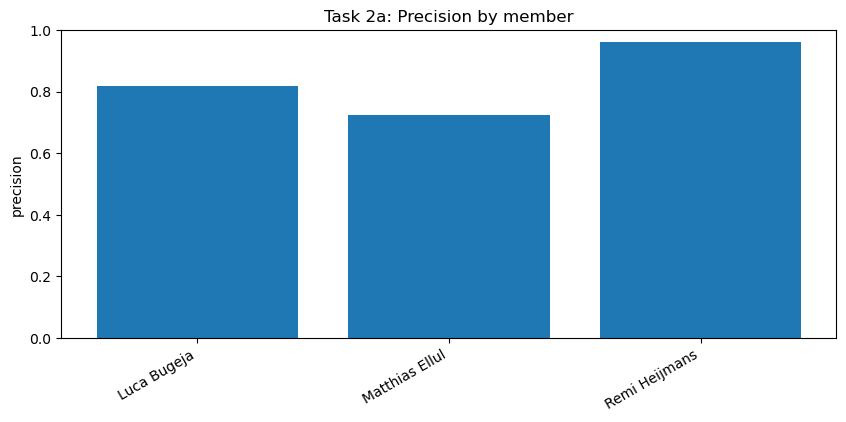

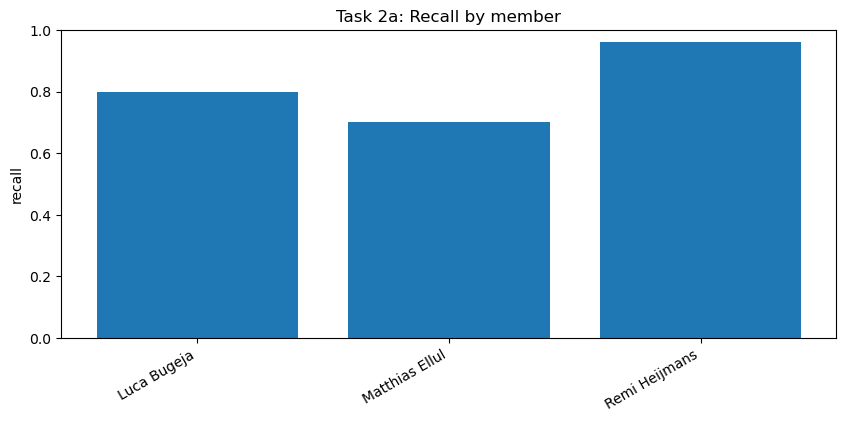

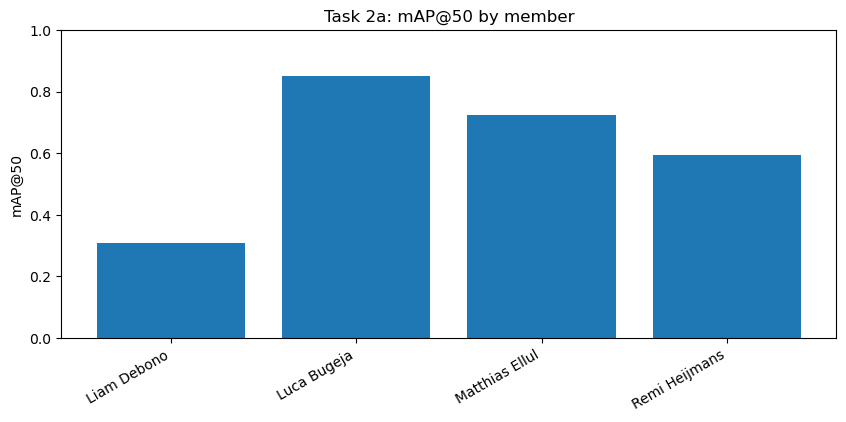

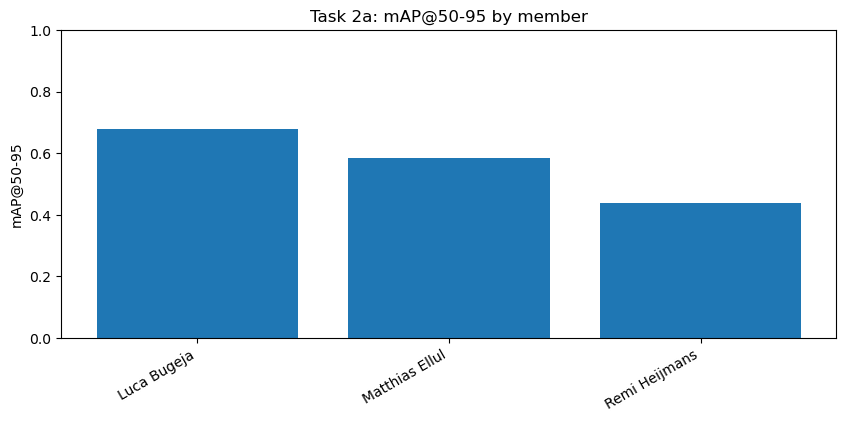

TASK 2B METRICS VISUALISATIONS


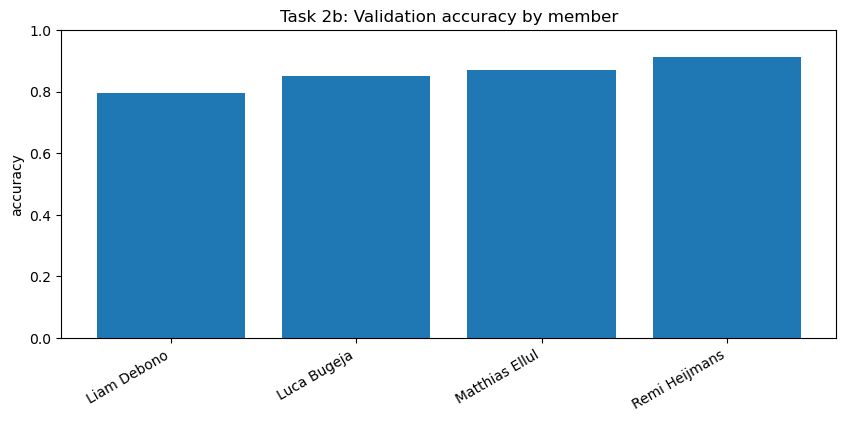

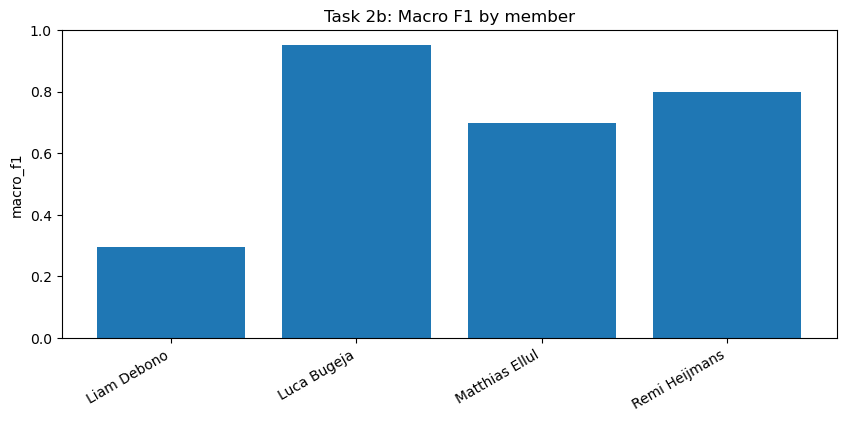

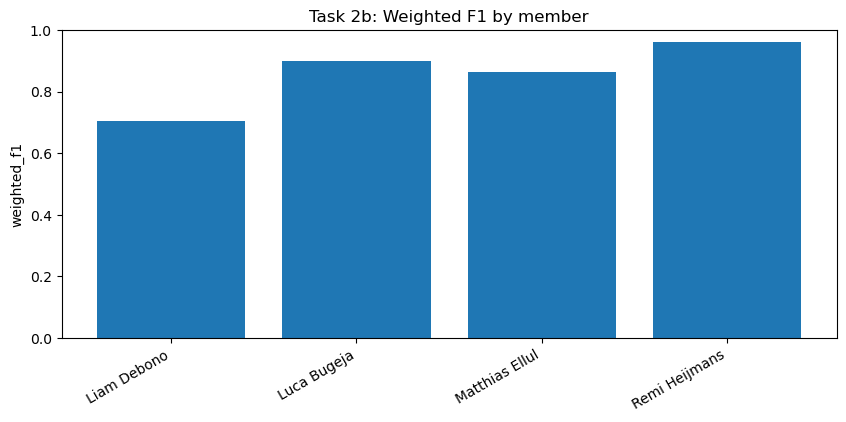

In [16]:
def barplot_metric(df: pd.DataFrame, metric: str, title: str):
    if df is None or len(df)==0 or metric not in df.columns:
        print(f'Nothing to plot for {metric}')
        return
    d = df[['member', metric]].dropna()
    if len(d)==0:
        print(f'No non-null values for {metric}')
        return
    plt.figure(figsize=(10, 4))
    plt.bar(d['member'], d[metric])
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel(metric)
    plt.xticks(rotation=30, ha='right')
    plt.show()

# Task 2a
print("TASK 2A METRICS VISUALISATIONS")
barplot_metric(df_det, 'precision', 'Task 2a: Precision by member')
barplot_metric(df_det, 'recall', 'Task 2a: Recall by member')
barplot_metric(df_det, 'mAP@50', 'Task 2a: mAP@50 by member')
barplot_metric(df_det, 'mAP@50-95', 'Task 2a: mAP@50-95 by member')

# Task 2b
print("TASK 2B METRICS VISUALISATIONS")
barplot_metric(df_clf, 'accuracy', 'Task 2b: Validation accuracy by member')
barplot_metric(df_clf, 'macro_f1', 'Task 2b: Macro F1 by member')
barplot_metric(df_clf, 'weighted_f1', 'Task 2b: Weighted F1 by member')